Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Nuclei:Classification for Pathology

### Training Notebook

This tutorial is to train a model for classifying nuclei cells as the following types.
 - Other
 - Inflammatory
 - Epithelial
 - Spindle-Shaped
 

### Features in the tutorial:
* Utilizes new transforms that were added/updated for v1.1 of MONAI.
* Data pre-processing functions, as typically pathology data is given as a whole slide, which cannot be directly used for training as it's too large in size, in particular check `split_concep_dataset`
* Uses the dataset: 

This model is trained using [DenseNet121](https://docs.monai.io/en/latest/networks.html#densenet121) over [ConSeP](https://warwick.ac.uk/fac/cross_fac/tia/data/hovernet) dataset.  

> Please note that this model uses existing label mask as additional signal input while training.

References:

[1] S. Graham, Q. D. Vu, S. E. A. Raza, A. Azam, Y-W. Tsang, J. T. Kwak and N. Rajpoot. "HoVer-Net: Simultaneous Segmentation and Classification of Nuclei in Multi-Tissue Histology Images." Medical Image Analysis, Sept. 2019. [[doi](https://doi.org/10.1016/j.media.2019.101563)]


## Setup environment

In [1]:
!python -c "import scipy" || pip install -q scipy
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import tqdm" || pip install -q tqdm
%matplotlib inline

## Setup imports

In [2]:
import copy
import glob
import json
import logging
import os
import pathlib
from typing import Any, Callable, Dict, List, Optional

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributed
from IPython.display import Image as IImage
from monai.apps.nuclick.transforms import AddLabelAsGuidanced, SetLabelClassd, SplitLabeld
from monai.apps.utils import download_and_extract
from monai.config import IgniteInfo, print_config
from monai.data import CacheDataset, DataLoader
from monai.engines import SupervisedEvaluator, SupervisedTrainer
from monai.handlers import CheckpointSaver, ConfusionMatrix, StatsHandler, ValidationHandler, from_engine
from monai.inferers import SimpleInferer
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activationsd,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    LoadImage,
    LoadImaged,
    RandFlipd,
    RandRotate90d,
    RandTorchVisiond,
    ScaleIntensityRangeD,
    SelectItemsd,
    ToTensord,
)
from monai.utils import min_version, optional_import
from PIL import Image, ImageDraw
from scipy.io import loadmat
from sklearn.metrics import classification_report
from tqdm import tqdm

print_config()

## Configure Workspace Path

Specify the workspace path where the data, models etc.. will be saved.



In [3]:
workspace_path = os.path.normpath('workspace/')
dry_run = True  # set it to False to run full training

## Configure Workspace Path

In [4]:
consep_zip = 'https://warwick.ac.uk/fac/cross_fac/tia/data/hovernet/consep_dataset.zip'
consep_dir = os.path.join(workspace_path, 'CoNSeP')

if not os.path.exists(consep_dir):
    download_and_extract(consep_zip, output_dir=workspace_path)

consep_dataset.zip: 146MB [00:23, 6.41MB/s]                                                                                                                                                                                                                    

2022-12-06 10:46:41,905 - INFO - Downloaded: /tmp/tmp834vb_2l/consep_dataset.zip
2022-12-06 10:46:41,907 - INFO - Expected md5 is None, skip md5 check for file /tmp/tmp834vb_2l/consep_dataset.zip.
2022-12-06 10:46:41,910 - INFO - Writing into directory: workspace.


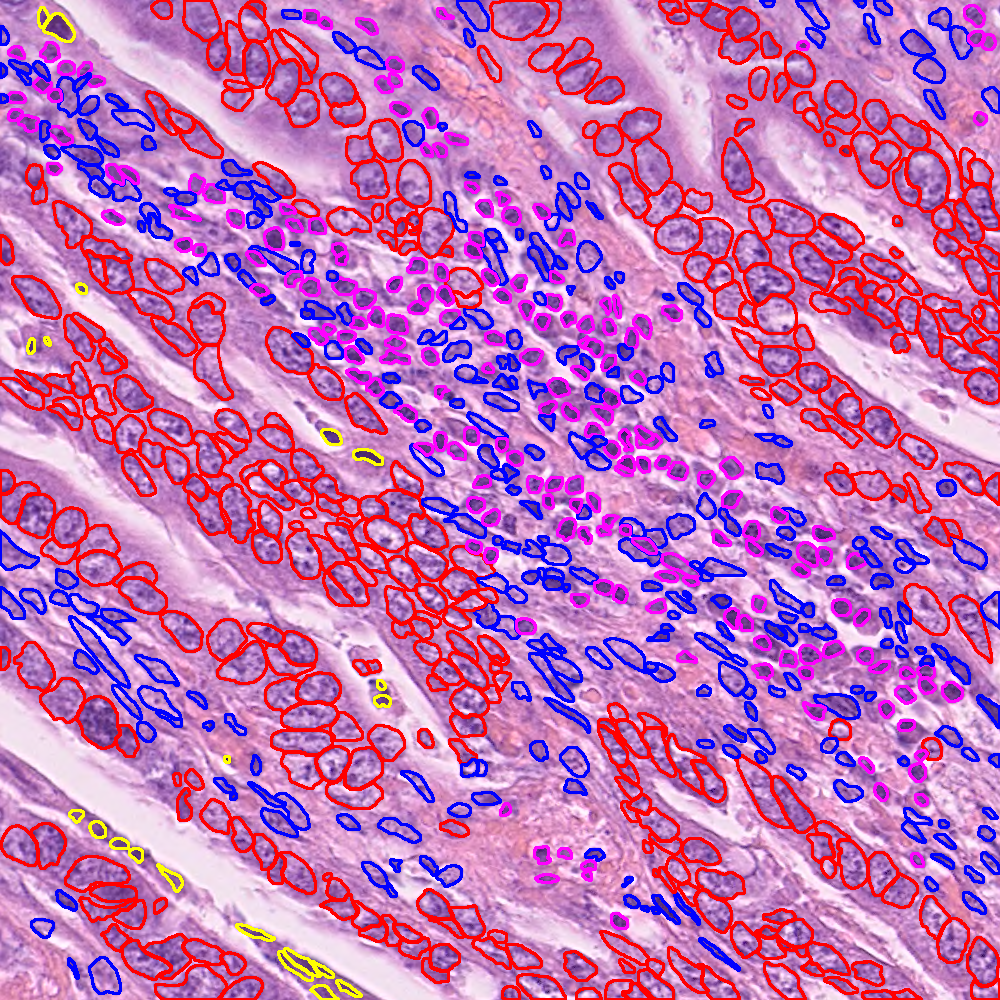

In [5]:
IImage(filename=os.path.join(consep_dir, "Train", "Overlay", "train_8.png"))

## Pre-processing utility functions

`consep_nuclei_dataset` reads the raw Image and Matlab files provided in ConSeP dataset.  For each Nuclei it tries to create a patch of 128x128 with single nuclei labeled with correspnding class index and rest of the nuclei falling in this patch are labeled as others (mask_value: 255)



In [6]:
def consep_nuclei_dataset(datalist, output_dir, crop_size, min_area=80, min_distance=20, limit=0) -> List[Dict]:
    """
    Utility to pre-process and create dataset list for Patches per Nuclei for training over ConSeP dataset.

    Args:
        datalist: A list of data dictionary. Each entry should at least contain 'image_key': <image filename>.
            For example, typical input data can be a list of dictionaries::

                [{'image': <image filename>, 'label': <label filename>}]

        output_dir: target directory to store the training data after flattening
        crop_size: Crop Size for each patch
        min_area: Min Area for each nuclei to be included in dataset
        min_distance: Min Distance from boundary for each nuclei to be included in dataset
        limit: limit number of inputs for pre-processing.  Defaults to 0 (no limit).

    Raises:
        ValueError: When ``datalist`` is Empty
        ValueError: When ``scipy.io.loadmat`` is Not available

    Returns:
        A new datalist that contains path to the images/labels after pre-processing.

    Example::

        datalist = consep_nuclei_dataset(
            datalist=[{'image': 'img1.png', 'label': 'label1.mat'}],
            output_dir=output,
            crop_size=128,
            limit=1,
        )

        print(datalist[0]["image"], datalist[0]["label"])
    """

    if not len(datalist):
        raise ValueError("Input datalist is empty")

    if not loadmat:
        print("Please make sure scipy with loadmat function is correctly installed")
        raise ValueError("scipy.io.loadmat module/function not found")

    dataset_json: List[Dict] = []
    for d in tqdm(datalist):
        # Image
        image = Image.open(d["image"]).convert("RGB")

        # Label
        m = loadmat(d["label"])
        instances = m["inst_map"]

        for nuclei_id, (class_id, (y, x)) in enumerate(zip(m["inst_type"], m["inst_centroid"]), start=1):
            x, y = (int(x), int(y))
            class_id = int(class_id)
            class_id = 3 if class_id in (3, 4) else 4 if class_id in (5, 6, 7) else class_id  # override

            if 0 < limit <= len(dataset_json):
                return dataset_json

            item = __prepare_patch(
                d=d,
                nuclei_id=nuclei_id,
                output_dir=output_dir,
                image=image,
                instances=instances,
                instance_idx=nuclei_id,
                crop_size=crop_size,
                class_id=class_id,
                centroid=(x, y),
                min_area=min_area,
                min_distance=min_distance,
                others_idx=255,
            )

            if item:
                dataset_json.append(item)

    return dataset_json


def __prepare_patch(
    d,
    nuclei_id,
    output_dir,
    image,
    instances,
    instance_idx,
    crop_size,
    class_id,
    centroid,
    min_area,
    min_distance,
    others_idx=255,
):
    image_np = np.array(image)
    image_size = image.size

    bbox = __compute_bbox(crop_size, centroid, image_size)

    cropped_label_np = instances[bbox[0]: bbox[2], bbox[1]: bbox[3]]
    cropped_label_np = np.array(cropped_label_np)

    this_label = np.where(cropped_label_np == instance_idx, class_id, 0)
    if np.count_nonzero(this_label) < min_area:
        return None

    x, y = centroid
    if x < min_distance or y < min_distance or (image_size[0] - x) < min_distance or (image_size[1] - y < min_distance):
        return None

    centroid = centroid[0] - bbox[0], centroid[1] - bbox[1]
    others = np.where(np.logical_and(cropped_label_np > 0, cropped_label_np != instance_idx), others_idx, 0)
    cropped_label_np = this_label + others
    cropped_label = Image.fromarray(cropped_label_np.astype(np.uint8), None)

    cropped_image_np = image_np[bbox[0]: bbox[2], bbox[1]: bbox[3], :]
    cropped_image = Image.fromarray(cropped_image_np, "RGB")

    images_dir = os.path.join(output_dir, "Images") if output_dir else "Images"
    labels_dir = os.path.join(output_dir, "Labels") if output_dir else "Labels"
    centroids_dir = os.path.join(output_dir, "Centroids") if output_dir else "Centroids"

    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)
    os.makedirs(centroids_dir, exist_ok=True)

    image_id = pathlib.Path(d["image"]).stem
    file_prefix = f"{image_id}_{class_id}_{str(instance_idx).zfill(4)}"
    image_file = os.path.join(images_dir, f"{file_prefix}.png")
    label_file = os.path.join(labels_dir, f"{file_prefix}.png")
    centroid_file = os.path.join(centroids_dir, f"{file_prefix}.txt")

    cropped_image.save(image_file)
    cropped_label.save(label_file)
    with open(centroid_file, "w") as fp:
        json.dump([centroid], fp)

    item = copy.deepcopy(d)
    item["nuclei_id"] = nuclei_id
    item["mask_value"] = class_id
    item["image"] = image_file
    item["label"] = label_file
    item["centroid"] = centroid
    return item


def __compute_bbox(patch_size, centroid, size):
    x, y = centroid
    m, n = size

    x_start = int(max(x - patch_size / 2, 0))
    y_start = int(max(y - patch_size / 2, 0))
    x_end = x_start + patch_size
    y_end = y_start + patch_size
    if x_end > m:
        x_end = m
        x_start = m - patch_size
    if y_end > n:
        y_end = n
        y_start = n - patch_size
    return x_start, y_start, x_end, y_end

## Create Json, form training and validation split


In [7]:
consep_nuclei_dir = os.path.join(workspace_path, 'CoNSePNuclei')
ds_file = os.path.join(consep_nuclei_dir, "dataset.json")
crop_size = 128
limit = 512 if dry_run else 0

if os.path.exists(ds_file):
    with open(ds_file) as fp:
        dataset_json = json.load(fp)
else:
    dataset_json = {}
    for f, v in {"Train": "training", "Test": "validation"}.items():
        print("---------------------------------------------------------------------------------")
        if not os.path.exists(os.path.join(consep_dir, f)):
            print(f"Ignore {f} (NOT Exists in Input Folder)")
            continue

        print(f"Processing Images/labels for: {f}")
        images_path = os.path.join(consep_dir, f, "Images", "*.png")
        labels_path = os.path.join(consep_dir, f, "Labels", "*.mat")
        images = sorted(glob.glob(images_path))
        labels = sorted(glob.glob(labels_path))
        ds = [{"image": i, "label": l} for i, l in zip(images, labels)]

        output_dir = os.path.join(consep_nuclei_dir, f) if consep_nuclei_dir else f

        ds_new = consep_nuclei_dataset(ds, output_dir, crop_size, limit=limit)
        print(f"Total Generated/Extended Records: {len(ds)} => {len(ds_new)}")

        dataset_json[v] = ds_new

    # Saving Dataset JSON for both training and validation
    with open(ds_file, "w") as fp:
        json.dump(dataset_json, fp, indent=2)

    print(f"Dataset JSON Generated at: {ds_file}")

print(f"Total Training   Records: {len(dataset_json['training'])}")
print(f"Total Validation Records: {len(dataset_json['validation'])}")

---------------------------------------------------------------------------------
Processing Images/labels for: Train


  0%|                                                                                                                                                                                                                                   | 0/27 [00:04<?, ?it/s]


Total Generated/Extended Records: 27 => 512
---------------------------------------------------------------------------------
Processing Images/labels for: Test


  0%|                                                                                                                                                                                                                                   | 0/14 [00:04<?, ?it/s]

Total Generated/Extended Records: 14 => 512
Dataset JSON Generated at: workspace/CoNSePNuclei/dataset.json
Total Training   Records: 512
Total Validation Records: 512


{
  "image": "workspace/CoNSePNuclei/Train/Images/train_1_3_0013.png",
  "label": "workspace/CoNSePNuclei/Train/Labels/train_1_3_0013.png",
  "nuclei_id": 13,
  "mask_value": 3,
  "centroid": [
    64,
    54
  ]
}
Mask Values: [  0   3 255]
-------------------------------------------------
This Nuclei
Image: torch.Size([128, 128, 3]); Label: (128, 128)


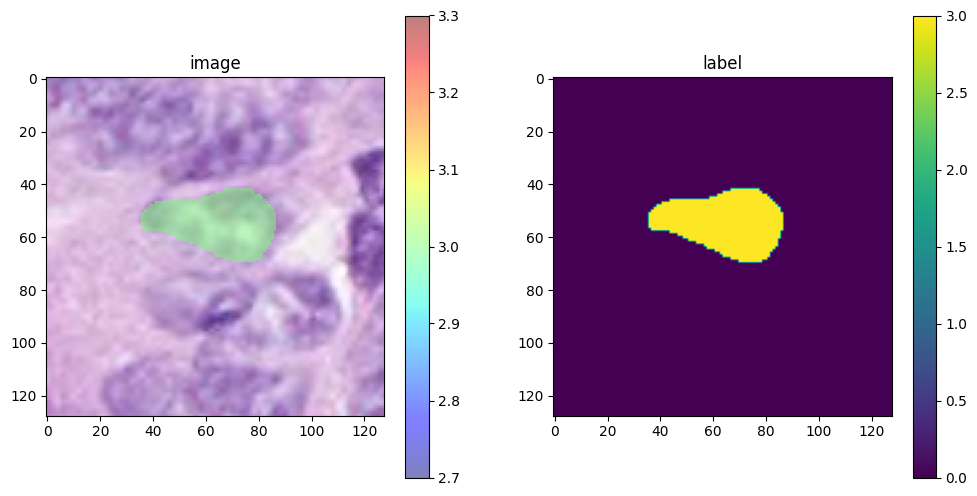

-------------------------------------------------
Others Nuclei
Image: torch.Size([128, 128, 3]); Label: (128, 128)


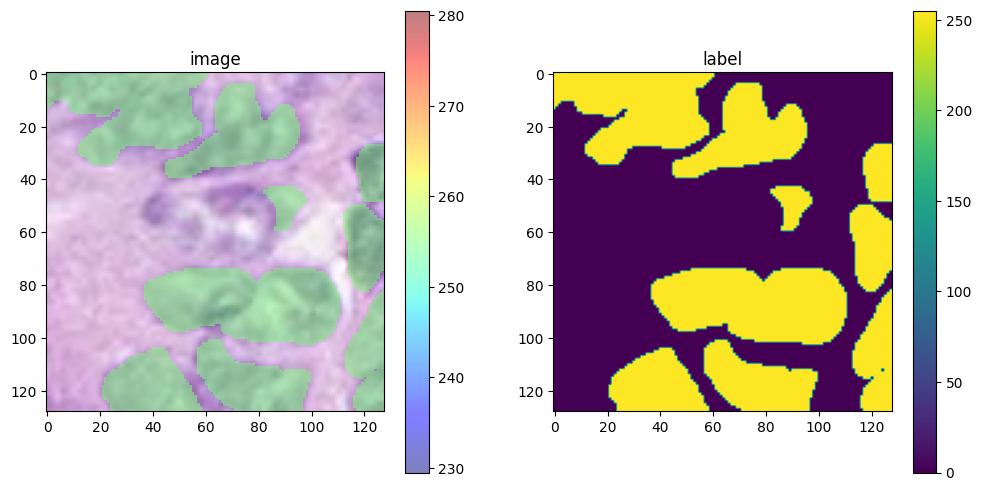

In [8]:
def show_image(image, label, points=None):
    print(f"Image: {image.shape}; Label: {label.shape}")

    if image.shape[0] == 3:
        image = np.moveaxis(image, 0, 2)
        label = np.moveaxis(label, 0, 2)

    plt.figure("check", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image, cmap="gray")

    if label is not None:
        masked = np.ma.masked_where(label == 0, label)
        plt.imshow(masked, 'jet', interpolation='none', alpha=0.5)

    if points is not None:
        draw_points(points)

    plt.colorbar()

    if label is not None:
        plt.subplot(1, 2, 2)
        plt.title("label")
        plt.imshow(label)
        plt.colorbar()
    plt.show()


def draw_points(guidance):
    if guidance is None:
        return
    colors = ['y+', 'b+']
    for color, points in zip(colors, guidance):
        print(points)
        for p in points:
            p1 = p[1]
            p2 = p[0]
            plt.plot(p1, p2, color, 'MarkerSize', 120)


print(json.dumps(dataset_json["training"][10], indent=2))
image = LoadImage(image_only=True, dtype=np.uint8)(dataset_json["training"][10]["image"])
label = LoadImage(image_only=True, dtype=np.uint8)(dataset_json["training"][10]["label"])
print(f"Mask Values: {np.unique(label)}")

print("-------------------------------------------------")
print("This Nuclei")
show_image(image, np.where(label < 255, label, 0))

print("-------------------------------------------------")
print("Others Nuclei")
show_image(image, np.where(label == 255, 255, 0))

## Training & Validation Transforms

In [9]:
class_names = {
    "0": "Other",
    "1": "Inflammatory",
    "2": "Epithelial",
    "3": "Spindle-Shaped",
}

# Transforms
train_pre_transforms = Compose([
    LoadImaged(keys=("image", "label"), dtype=np.uint8),
    EnsureChannelFirstd(keys=("image", "label")),
    SplitLabeld(keys="label", mask_value=None, others_value=255, to_binary_mask=False),
    RandTorchVisiond(
        keys="image",
        name="ColorJitter",
        brightness=64.0 / 255.0,
        contrast=0.75,
        saturation=0.25,
        hue=0.04,
    ),
    RandFlipd(keys=("image", "label", "others"), prob=0.5),
    RandRotate90d(keys=("image", "label", "others"), prob=0.5, spatial_axes=(0, 1)),
    ScaleIntensityRangeD(keys="image", a_min=0.0, a_max=255.0, b_min=-1.0, b_max=1.0),
    AddLabelAsGuidanced(keys="image", source="label"),
    SetLabelClassd(keys="label", offset=-1),
    SelectItemsd(keys=("image", "label")),
])

train_post_transforms = Compose([
    Activationsd(keys="pred", sigmoid=True),
    AsDiscreted(keys=("pred", "label"), argmax=(True, False), to_onehot=len(class_names)),
    ToTensord(keys=("pred", "label"), device="cuda")
])

val_transforms = Compose([
    LoadImaged(keys=("image", "label"), dtype=np.uint8),
    EnsureChannelFirstd(keys=("image", "label")),
    SplitLabeld(keys="label", mask_value=None, others_value=255, to_binary_mask=False),
    ScaleIntensityRangeD(keys="image", a_min=0.0, a_max=255.0, b_min=-1.0, b_max=1.0),
    AddLabelAsGuidanced(keys="image", source="label"),
    SetLabelClassd(keys="label", offset=-1),
    SelectItemsd(keys=("image", "label")),
])

val_pos_transforms = train_post_transforms

## Tensorboard Handler to verify Input/Output

In [10]:
Events, _ = optional_import("ignite.engine", IgniteInfo.OPT_IMPORT_VERSION, min_version, "Events")
make_grid, _ = optional_import("torchvision.utils", name="make_grid")
Engine, _ = optional_import("ignite.engine", IgniteInfo.OPT_IMPORT_VERSION, min_version, "Engine")
SummaryWriter, _ = optional_import("torch.utils.tensorboard", name="SummaryWriter")


class TensorBoardImageHandler:
    def __init__(
        self,
        class_names,
        summary_writer: Optional[SummaryWriter] = None,
        log_dir: str = "./runs",
        tag_name="val",
        interval: int = 1,
        batch_transform: Callable = lambda x: x,
        output_transform: Callable = lambda x: x,
        batch_limit=1,
        device=None,
    ) -> None:
        self.class_names = class_names
        self.writer = SummaryWriter(log_dir=log_dir) if summary_writer is None else summary_writer
        self.tag_name = tag_name
        self.interval = interval
        self.batch_transform = batch_transform
        self.output_transform = output_transform
        self.batch_limit = batch_limit
        self.device = device

        self.logger = logging.getLogger(__name__)

        if torch.distributed.is_initialized():
            self.tag_name = f"{self.tag_name}-r{torch.distributed.get_rank()}"
        self.class_y: List[Any] = []
        self.class_y_pred: List[Any] = []

    def attach(self, engine: Engine) -> None:
        if self.interval == 1:
            engine.add_event_handler(Events.ITERATION_COMPLETED(every=self.interval), self, "iteration")
        engine.add_event_handler(Events.EPOCH_COMPLETED(every=self.interval), self, "epoch")

    def __call__(self, engine: Engine, action) -> None:
        epoch = engine.state.epoch
        batch_data = self.batch_transform(engine.state.batch)
        output_data = self.output_transform(engine.state.output)

        if action == "iteration":
            for bidx in range(len(batch_data)):
                y = output_data[bidx]["label"].detach().cpu().numpy()
                y_pred = output_data[bidx]["pred"].detach().cpu().numpy()

                self.class_y.append(np.argmax(y))
                self.class_y_pred.append(np.argmax(y_pred))
            return

        self.write_metrics(epoch)
        self.write_images(batch_data, output_data, epoch)
        self.writer.flush()

    def write_images(self, batch_data, output_data, epoch):
        for bidx in range(len(batch_data)):
            image = batch_data[bidx]["image"].detach().cpu().numpy()
            y = output_data[bidx]["label"].detach().cpu().numpy()
            y_pred = output_data[bidx]["pred"].detach().cpu().numpy()

            sig_np = image[:3] * 128 + 128
            sig_np[0, :, :] = np.where(image[3] > 0, 1, sig_np[0, :, :])

            y_c = np.argmax(y)
            y_pred_c = np.argmax(y_pred)

            tag_prefix = f"{self.tag_name} - b{bidx} - " if self.batch_limit != 1 else f"{self.tag_name} - "
            label_pred_tag = f"{tag_prefix}Image/Signal/Label/Pred:"

            y_img = Image.new("RGB", image.shape[-2:])
            draw = ImageDraw.Draw(y_img)
            draw.text((10, 50), self.class_names.get(f"{y_c}", f"{y_c}"))

            y_pred_img = Image.new("RGB", image.shape[-2:], "green" if y_c == y_pred_c else "red")
            draw = ImageDraw.Draw(y_pred_img)
            draw.text((10, 50), self.class_names.get(f"{y_pred_c}", f"{y_pred_c}"))

            img_tensor = make_grid(
                tensor=[
                    torch.from_numpy(sig_np),
                    torch.from_numpy(np.stack((np.where(image[3] > 0, 255, 0),) * 3)),
                    torch.from_numpy(np.moveaxis(np.array(y_img), -1, 0)),
                    torch.from_numpy(np.moveaxis(np.array(y_pred_img), -1, 0)),
                ],
                nrow=4,
                normalize=True,
                pad_value=10,
            )
            self.writer.add_image(tag=label_pred_tag, img_tensor=img_tensor, global_step=epoch)

            if self.batch_limit == 1 or bidx == (self.batch_limit - 1):
                break

    def write_metrics(self, epoch):
        cr = classification_report(self.class_y, self.class_y_pred, output_dict=True, zero_division=0)
        for k, v in cr.items():
            if isinstance(v, dict):
                ltext = []
                cname = self.class_names.get(k, k)
                for n, m in v.items():
                    ltext.append(f"{n} => {m:.4f}")
                    self.writer.add_scalar(f"{self.tag_name}_cr_{cname}_{n}", m, epoch)

                self.logger.info(f"{self.tag_name} => Epoch[{epoch}] - {cname} - Metrics -- {'; '.join(ltext)}")
            else:
                self.logger.info(f"{self.tag_name} => Epoch[{epoch}] Metrics -- {k} => {v:.4f}")
                self.writer.add_scalar(f"{self.tag_name}_cr_{k}", v, epoch)

        self.class_y = []
        self.class_y_pred = []

## Training of NuClick Model

In [ ]:
train_key_metric = {"train_f1": ConfusionMatrix(
    output_transform=from_engine(["pred", "label"]), metric_name="f1 score")}
val_key_metric = {"val_f1": ConfusionMatrix(output_transform=from_engine(["pred", "label"]), metric_name="f1 score")}
val_inferer = SimpleInferer()
log_dir = os.path.join(workspace_path, "train_run_01")


amp = True
max_epochs = 5 if dry_run else 50

# Define Dataset & Loading
train_data_set = CacheDataset(dataset_json["training"], transform=train_pre_transforms)
train_data_loader = DataLoader(dataset=train_data_set, batch_size=64, shuffle=True, num_workers=0)

val_data_set = CacheDataset(dataset_json["validation"], transform=val_transforms)
val_data_loader = DataLoader(dataset=val_data_set, batch_size=64, shuffle=False, num_workers=0)

# Network Definition, Optimizer etc
device = torch.device("cuda")
network = DenseNet121(spatial_dims=2, in_channels=4, out_channels=len(class_names))


network.to(device)
optimizer = torch.optim.Adam(network.parameters(), 0.0001)
ce_loss = torch.nn.CrossEntropyLoss()

# Training Process
val_handlers = [
    TensorBoardImageHandler(class_names, log_dir=log_dir, batch_limit=4, tag_name="val"),
    CheckpointSaver(save_dir=log_dir, save_dict={"model": network},
                    save_key_metric=True, key_metric_filename="model.pt"),
]

evaluator = SupervisedEvaluator(
    device=device,
    val_data_loader=val_data_loader,
    network=network,
    inferer=val_inferer,
    postprocessing=train_post_transforms,
    key_val_metric=val_key_metric,
    val_handlers=val_handlers,
    amp=amp,
)

train_handlers = [
    ValidationHandler(validator=evaluator, interval=1, epoch_level=True),
    StatsHandler(tag_name="train_loss", output_transform=from_engine(["loss"], first=True)),
    TensorBoardImageHandler(class_names, log_dir=log_dir, batch_limit=4, tag_name="train"),
]

trainer = SupervisedTrainer(
    device=device,
    max_epochs=max_epochs,
    train_data_loader=train_data_loader,
    network=network,
    optimizer=optimizer,
    loss_function=ce_loss,
    inferer=SimpleInferer(),
    amp=amp,
    postprocessing=train_post_transforms,
    key_train_metric=train_key_metric,
    train_handlers=train_handlers,
)
trainer.run()

The results can be visualizaed by passing the logging_dir variable path to tensorboard. 

For example: `tensorboard --logdir=workspace\train_run_01`


## Scores
This model achieves the following F1 score on the validation data provided as part of the dataset:

- Train F1 score = 0.96
- Validation F1 score = 0.85



## Training Performance
A graph showing the training Loss and F1-score over 50 epochs.

![Train Loss](https://github.com/Project-MONAI/model-zoo/raw/dev/models/pathology_nuclei_classification/docs/images/train_loss.jpeg)
![Train F1](https://github.com/Project-MONAI/model-zoo/raw/dev/models/pathology_nuclei_classification/docs/images/train_f1.jpeg)

## Validation Performance
A graph showing the validation F1-score over 50 epochs.

![Val F1](https://github.com/Project-MONAI/model-zoo/raw/dev/models/pathology_nuclei_classification/docs/images/val_f1.jpeg)




## End of Notebook